In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns 
from datetime import datetime

from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

from functions import *


/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
vse_samodejne = read_txt('VSE SAMODEJNE 2022.txt')

# sunek vetra
df = vse_samodejne.loc[vse_samodejne["sunki vetra [m/s]"] == 999.0, "sunki vetra [m/s]"] = np.nan
df = vse_samodejne.astype({'sunki vetra [m/s]':'float'})

# negativno globalno sevanje
df.loc[vse_samodejne['globalno sev. [W/m2]'] < 0, 'globalno sev. [W/m2]']= np.nan

# postaje, ki imajo podatek za difuzno sevanje
df = df[~df['difuzno sev. [W/m2]'].isna()]

# preimenujem difuzno sevanje in valid
df = df.rename(columns={'difuzno sev. [W/m2]': 'DF', ' valid': 'date'})

In [3]:
# postaja CELJE - nima difuznega sevanja
data = df[df[' station name'] == "ROGLA"]
data = data.dropna(axis=1)

#data.reset_index(inplace = True)
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")

target = data.loc[:,["DF"]]

del data[" station name"], data["station id"], data["DF"]


## 1. Only target feature - LSTM

In [4]:
# convert series to supervised learning
def data_preparation(data, window=1, look_forward=1, dropnan=True):
    # window = okno(pogledas nazaj)
    # look_forward = pogled naprej

    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(data.shape[1])]
        # forecast sequence (t, t+1, ... t+n)
    
    # current timestep (t=0)
    for i in range(0, look_forward):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(data.shape[1])]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(data.shape[1])]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.iloc[:,:data.shape[1] * window], agg.iloc[:,[agg.shape[1] - 1]]



### 1.1. Data preparation

In [5]:
# data preparation

# split data
look_back = 48
target_train = data.iloc[:int(len(data) * 0.7),data.shape[1] - 1].values
target_val = data.iloc[(int(len(data) * 0.7) - look_back):int(len(data) * 0.9),data.shape[1] - 1].values
target_test = data.iloc[(int(len(data) * 0.9) - look_back):,data.shape[1] - 1].values

# scale data
scaler = StandardScaler().fit(target_train.reshape(-1,1))
target_train = scaler.transform(target_train.reshape(-1,1))
target_val = scaler.transform(target_val.reshape(-1,1))
target_test = scaler.transform(target_test.reshape(-1,1))

# train, target
x_train,  y_train = data_preparation(target_train, look_back)
x_val,  y_val = data_preparation(target_val, look_back)
x_test,  y_test = data_preparation(target_test, look_back)
x_train.shape, x_val.shape, x_test.shape

# reshape
x_train = np.reshape(x_train.values, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val.values, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test.values, (x_test.shape[0], x_test.shape[1], 1))
x_train.shape, x_val.shape, x_test.shape

((12216, 48, 1), (3504, 48, 1), (1752, 48, 1))

### 1.2. LSTM model

In [6]:
# build the LSTM model
regression = Sequential(name = 'LSTM')

regression.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regression.add(Dropout(0.5))

regression.add(LSTM(64, return_sequences=True))
regression.add(Dropout(0.5))

regression.add(LSTM(32, return_sequences=False))
regression.add(Dropout(0.5))

regression.add(Dense(1))

# compile the regression
regression.compile(optimizer='adam', loss='mean_squared_error')

regression.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 48, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33     

In [7]:
# train the model
lstm1 = regression.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
96/96 [==============================] - 17s 146ms/step - loss: 0.3169 - val_loss: 0.0669
Epoch 2/50
96/96 [==============================] - 15s 152ms/step - loss: 0.1835 - val_loss: 0.0491
Epoch 3/50
96/96 [==============================] - 15s 154ms/step - loss: 0.1580 - val_loss: 0.0346
Epoch 4/50
96/96 [==============================] - 14s 147ms/step - loss: 0.1391 - val_loss: 0.0287
Epoch 5/50
96/96 [==============================] - 14s 148ms/step - loss: 0.1321 - val_loss: 0.0266
Epoch 6/50
96/96 [==============================] - 14s 147ms/step - loss: 0.1255 - val_loss: 0.0244
Epoch 7/50
96/96 [==============================] - 14s 148ms/step - loss: 0.1113 - val_loss: 0.0235
Epoch 8/50
96/96 [==============================] - 15s 152ms/step - loss: 0.1147 - val_loss: 0.0190
Epoch 9/50
96/96 [==============================] - 15s 157ms/step - loss: 0.1110 - val_loss: 0.0198
Epoch 10/50
96/96 [==============================] - 15s 157ms/step - loss: 0.1091 - val_lo

In [8]:
y_test_sc = scaler.inverse_transform(y_test)
predicted = regression.predict(x_test)
predicted_df = scaler.inverse_transform(predicted)
print(f'LSTM rmse = {math.sqrt(mean_squared_error(y_test_sc, predicted_df)):.4f}')

55/55 [==============================] - 2s 19ms/step
LSTM rmse = 0.0226


### 1.3. Plot the predictions

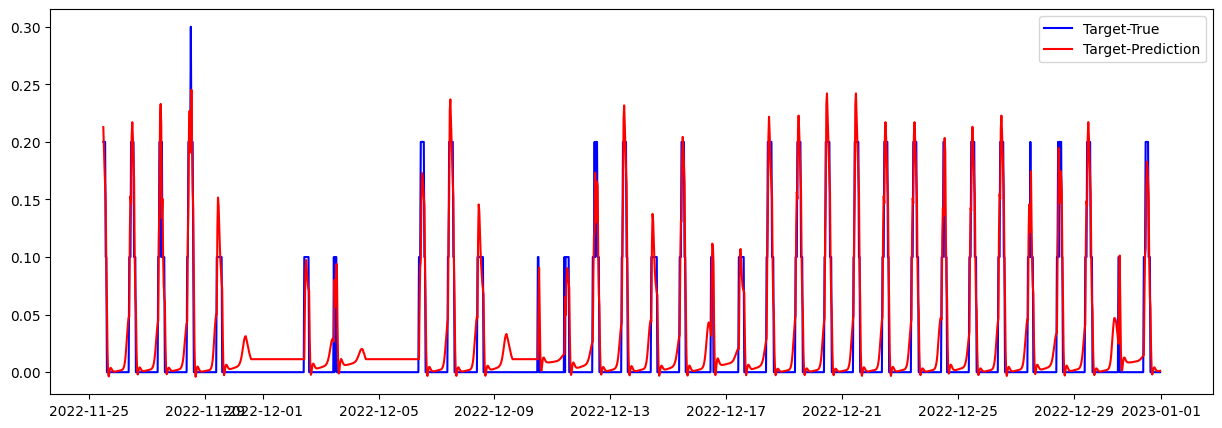

In [9]:
df_plot = pd.DataFrame({
    "time" : data.iloc[int(len(data) * 0.9):len(data),].index,
    "target_true" : y_test_sc.squeeze(),
    "target_pred" : predicted_df.squeeze()
})

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_plot["time"], df_plot["target_true"], color = "blue", label = 'Target-True')
ax.plot(df_plot["time"], df_plot["target_pred"], color = "red", label = 'Target-Prediction')
plt.legend()

In [10]:
df_plot

,time,target_true,target_pred
0,2022-11-25 12:00:00,0.2,0.212889
1,2022-11-25 12:30:00,0.2,0.193984
2,2022-11-25 13:00:00,0.2,0.176838
3,2022-11-25 13:30:00,0.2,0.161802
4,2022-11-25 14:00:00,0.1,0.147776
...,...,...,...
1747,2022-12-31 21:30:00,0.0,0.000857
1748,2022-12-31 22:00:00,0.0,0.000856
1749,2022-12-31 22:30:00,0.0,0.000934
1750,2022-12-31 23:00:00,0.0,0.001051


## 2. LSTM multivariable

### 2.1. TimeseriesGenerator

In [11]:
data = data.values
data

array([[ 9.1,  9.3,  9.1, ...,  6.8,  0. ,  0. ],
       [ 8.8,  8.8,  8.8, ...,  7.7,  0. ,  0. ],
       [10. ,  9.5,  9.3, ..., 14.4,  0. ,  0. ],
       ...,
       [ 6.7,  6.4,  6. , ...,  7.6,  0. ,  0. ],
       [ 4.3,  4.9,  4.3, ...,  7.7,  0. ,  0. ],
       [ 4.9,  5.2,  4.8, ...,  8.8,  0. ,  0. ]])

In [12]:
target = target.values
target

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [13]:
# normalize the dataset
scaler = StandardScaler()
scaler.fit_transform(target)
#data_x= scaler.transform(data)
data_y = scaler.transform(target)

In [14]:
# split into train and test sets
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train_x, test_x = data[0:train_size,:], data[train_size:len(data),:]
train_y, test_y = data_y[0:train_size,:], data_y[train_size:len(data_y),:]

In [15]:
look_back = 48 

In [16]:
train_data_gen = TimeseriesGenerator(train_x, train_y,
                                     length=look_back, sampling_rate=1, stride=1,
                                     batch_size=128)

In [17]:
test_data_gen = TimeseriesGenerator(test_x, test_y,
                                    length=look_back, sampling_rate=1,stride=1,
                                    batch_size=1)

### 2.2. LSTM model

In [18]:
# build the LSTM model
regression = Sequential(name = 'LSTM')

regression.add(LSTM(128, return_sequences=True, input_shape=(look_back, train_x.shape[1])))
regression.add(Dropout(0.5))

regression.add(LSTM(64, return_sequences=True))
regression.add(Dropout(0.5))

regression.add(LSTM(32, return_sequences=False))
regression.add(Dropout(0.5))

regression.add(Dense(1))

# compile the regression
regression.compile(optimizer='adam', loss='mean_squared_error')

regression.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 48, 128)           73216     
                                                                 
 dropout_3 (Dropout)         (None, 48, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 48, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 48, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33     

In [19]:
lstm1 = regression.fit(train_data_gen, epochs=100)

Epoch 1/100


96/96 [==============================] - 15s 132ms/step - loss: 0.7010
Epoch 2/100
96/96 [==============================] - 13s 136ms/step - loss: 0.5330
Epoch 3/100
96/96 [==============================] - 13s 136ms/step - loss: 0.5233
Epoch 4/100
96/96 [==============================] - 13s 137ms/step - loss: 0.4641
Epoch 5/100
96/96 [==============================] - 13s 137ms/step - loss: 0.4590
Epoch 6/100
96/96 [==============================] - 13s 137ms/step - loss: 0.4397
Epoch 7/100
96/96 [==============================] - 14s 146ms/step - loss: 0.4332
Epoch 8/100
96/96 [==============================] - 14s 150ms/step - loss: 0.4120
Epoch 9/100
96/96 [==============================] - 14s 144ms/step - loss: 0.3947
Epoch 10/100
96/96 [==============================] - 13s 138ms/step - loss: 0.3920
Epoch 11/100
96/96 [==============================] - 13s 134ms/step - loss: 0.3839
Epoch 12/100
96/96 [==============================] - 13s 134ms/step - loss: 0.3759
Epoch 13/100


In [20]:
regression.evaluate(test_data_gen)

5208/5208 [==============================] - 36s 7ms/step - loss: 0.1854


0.1853596568107605

In [21]:
train_predict = regression.predict(train_data_gen)
train_predict.shape

96/96 [==============================] - 6s 54ms/step


(12216, 1)

In [22]:
test_predict = regression.predict(test_data_gen)
test_predict.shape

5208/5208 [==============================] - 34s 7ms/step


(5208, 1)

In [23]:
# invert predictions, scale values back to real index
train_predict = scaler.inverse_transform(train_predict)
test_redict = scaler.inverse_transform(test_predict)
dataset_y = scaler.inverse_transform(data_y)

In [24]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [25]:
train_Y = get_y_from_generator(train_data_gen)
test_Y = get_y_from_generator(test_data_gen)
train_Y = scaler.inverse_transform(train_Y)
test_Y = scaler.inverse_transform(test_Y)

(12216, 1)
(5208, 1)


In [26]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_Y[:,0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_Y[:, 0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 36.03 RMSE
Test Score: 69.97 RMSE


### 2.3. Plot the predictions

In [27]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# Delta + previous close
trainPredictPlot = trainPredictPlot + target[0:]


# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(dataset_y), :] = test_predict

# Delta + previous close
testPredictPlot = testPredictPlot + target[0:]


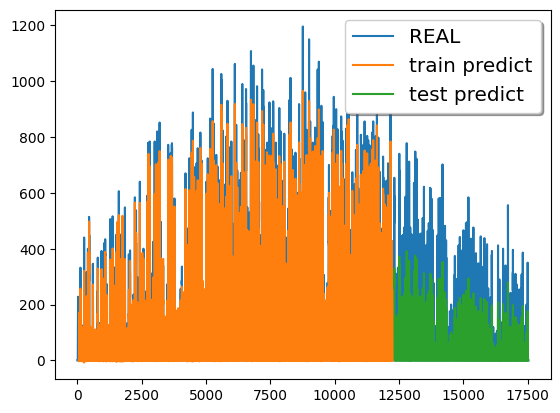

In [28]:
fig, ax = plt.subplots()
ax.plot(dataset_y + target[0:], label='REAL')
ax.plot(trainPredictPlot, label='train predict')
ax.plot(testPredictPlot, label='test predict')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

plt.show()